In [1]:
!pip install pydicom
import math
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pydicom
from pydicom import dcmread
from PIL import Image
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.backend import flatten
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report,confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 16.2 MB/s 


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/unique_df.csv')

In [ ]:
def create_mask(list1):
  for i in range(len(list1)):
    list1[i] = [int(item) for item in list1[i]]
  dim = np.zeros((1024,1024,))
  for i in range(len(list1)):
    x,y,w,h = list1[i]
    dim[x:x+w,y:y+h] = 1
  return dim

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, IMG_SIZE=None, n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.IMG_SIZE = IMG_SIZE
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.dim = (IMG_SIZE,IMG_SIZE)
        self.on_epoch_end()
        self.mapping = {k:v for k,v in zip(self.list_IDs,self.labels) }
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            # Store sample
            img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/converted_train_images/' + ID + '.dcm.jpg')

            #preprocessing of X-Ray
            grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
            image = clahe.apply(grayimg) 
            fimg = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

            #normalizing the image 
            fimg = fimg/fimg.max()
            fimg = fimg.astype('float')

            #Store Images
            X[i,] = cv2.resize(fimg, (IMG_SIZE,IMG_SIZE))

            # Store masks
            lst = self.mapping[ID]
            mask1 = create_mask(lst)
            y[i] = np.expand_dims(cv2.resize(mask1,(IMG_SIZE,IMG_SIZE)),-1)

        return X,y

train_gen[batch no][X:0><Y:1][ith image in batch(range of i is 0 to 3]



In [ ]:
Train = pd.read_csv('/content/drive/MyDrive/Data/Train.csv')
Val = pd.read_csv('/content/drive/MyDrive/Data/Valid.csv')
Test = pd.read_csv('/content/drive/MyDrive/Data/Test.csv')

Train = Train.sample(frac=0.6,random_state=42)
Val = Val.sample(frac=0.6,random_state=42)

In [ ]:
Train['Masks'] = Train['Masks'].apply(lambda x: eval(x))
Test['Masks'] = Test['Masks'].apply(lambda x: eval(x))
Val['Masks'] = Val['Masks'].apply(lambda x: eval(x))

In [ ]:
batch_size=8
IMG_SIZE=512
Train_gen = DataGenerator(list(Train.patientId),
                          list(Train.Masks),
                          batch_size=batch_size,
                          IMG_SIZE=IMG_SIZE,
                          shuffle=True)
print(len(Train_gen))

1400


In [ ]:
batch_size=8
IMG_SIZE=512
Val_gen = DataGenerator(list(Val.patientId),
                          list(Val.Masks),
                          batch_size=batch_size,
                          IMG_SIZE=IMG_SIZE,
                          shuffle=True)
print(len(Val_gen))

300


In [ ]:
batch_size=1
IMG_SIZE=512
Test_gen = DataGenerator(list(Test.patientId),
                          list(Test.Masks),
                          batch_size=batch_size,
                          IMG_SIZE=IMG_SIZE,
                          shuffle=False)
print(len(Test_gen))

4003


In [ ]:
def mask_visualization(data,bno):
  for bi in range(8):
    fig = plt.figure(figsize=(15,10))
    rows=1
    columns=3

    fig.add_subplot(rows,columns,1)
    # showing auto
    plt.imshow(data[bno][0][bi][:,:,-1],cmap='gray')
    plt.axis('image')
    plt.title("Xray")

    fig.add_subplot(rows,columns,2)
    # showing auto
    plt.imshow(data[bno][1][bi][:,:,-1],cmap='jet',alpha=0.3)
    plt.axis('image')
    plt.title("Mask")

    fig.add_subplot(rows,columns,3)
    # showing auto
    plt.imshow(data[bno][0][bi][:,:,-1],cmap='gray')
    plt.imshow(data[bno][1][bi][:,:,-1],cmap='jet',alpha=0.3)
    plt.axis('image')
    plt.title("Masked X-Ray")

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.2 MB/s 


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [ ]:
model = sm.Unet(backbone_name='inceptionv3',
                         input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         classes=1, activation='sigmoid',
                         weights=None,
                         encoder_weights='imagenet',
                         encoder_freeze=False,
                         encoder_features='default',
                         decoder_block_type='upsampling',
                         decoder_filters=(256, 128, 64, 32, 16),
                         decoder_use_batchnorm=True)

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
smooth = 0.000001
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f1 = K.flatten(K.round(y_pred))
    intersection = K.sum(y_true_f * y_pred_f1)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f1) + smooth)

In [ ]:
smooth = 0.000001
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
def weighted_bce_dice_loss(y_true, y_pred):
    return 0.85*binary_crossentropy(y_true, y_pred) + 0.15*dice_loss(y_true, y_pred)

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model.compile(optimizer = adam, loss = binary_crossentropy , metrics=['accuracy',dice_coef])

In [ ]:
from tensorflow.keras.callbacks import CSVLogger,ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

base_model_path = '/content/drive/MyDrive/weights'
model_checkpoint = ModelCheckpoint(
        os.path.join(base_model_path,'Unet_Inception_1_min_val_loss.hdf5'),
        monitor="val_loss", mode='min',save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True, verbose=1)

model_checkpoint_dice = ModelCheckpoint(
        os.path.join(base_model_path,'Unet_Inception_1_max_val_dice.hdf5'),
        monitor="val_dice_coef", mode='max',save_best_only=True, verbose=1)

csv_path = '/content/drive/MyDrive/logs/Unet_Inception_1.csv' 
csv_logger = CSVLogger(csv_path, append=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-7)

callbacks = [model_checkpoint, model_checkpoint_dice, reduce_lr, early_stop,csv_logger]

In [ ]:
#TRAINING
if os.path.exists(csv_path):
    os.remove(csv_path)

model.fit(Train_gen,
          validation_data=Val_gen,
          epochs=10,
          verbose=1,
          callbacks=callbacks)

Epoch 1/10
1400/1400 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9641 - dice_coef: 0.0409
Epoch 1: val_loss improved from inf to 0.08807, saving model to /content/drive/MyDrive/weights/Unet_Inception_1_min_val_loss.hdf5

Epoch 1: val_dice_coef improved from -inf to 0.08742, saving model to /content/drive/MyDrive/weights/Unet_Inception_1_max_val_dice.hdf5
1400/1400 [==============================] - 12890s 9s/step - loss: 0.1552 - accuracy: 0.9641 - dice_coef: 0.0409 - val_loss: 0.0881 - val_accuracy: 0.9748 - val_dice_coef: 0.0874 - lr: 1.0000e-04
Epoch 2/10
1400/1400 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9721 - dice_coef: 0.2664
Epoch 2: val_loss improved from 0.08807 to 0.07802, saving model to /content/drive/MyDrive/weights/Unet_Inception_1_min_val_loss.hdf5

Epoch 2: val_dice_coef improved from 0.08742 to 0.33941, saving model to /content/drive/MyDrive/weights/Unet_Inception_1_max_val_dice.hdf5
1400/1400 [===============

In [ ]:
model.load_weights('/content/drive/MyDrive/weights/Unet_Inception_1_min_val_loss.hdf5')

In [ ]:
def plot_masks(img,true,pred):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img)
  # plt.imshow(Test_gen[0][1][i][:,:,-1],cmap='jet',alpha=0.3)
  plt.imshow(true,cmap='jet',alpha=0.3)

  plt.subplot(1,2,2)
  plt.imshow(img)
  # plt.imshow(np.squeeze(model.predict(Test_gen[i][0])),cmap='jet',alpha =0.3)
  plt.imshow(pred,cmap='jet',alpha=0.3)

In [ ]:
# lst = list(Test[Test['Target'] == 1].index)
pred_prob = []
for i in tqdm(range(len(Test_gen))):
  img = np.squeeze(Test_gen[i][0])
  # pred_prob.append(np.squeeze(model.predict(Test_gen[i][0])))
  true = np.squeeze(Test_gen[i][1])
  pred=np.squeeze(model.predict(Test_gen[i][0]))
  plot_masks(img,true,pred)
  if(i==100): break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Test['pred_label']= Test.pred_prob.apply(lambda x: 1 if x>0.32 else 0)

In [ ]:
TN, FP, FN, TP = confusion_matrix(Test.Target,Test.pred_label).ravel()

In [ ]:
print(FP)

572


In [ ]:
Precision = TP/(TP+FP)
Recall = TP / (FN+TP)

In [ ]:
print("Sensitivity:", TP / (FN+TP))
print("Specificity:", TN/(FP+TN))
print("Recall:", TP / (FN+TP))
print("Precision:", TP/(TP+FP))
print("F1-Score:", 2 * (Precision * Recall)/ (Precision + Recall))

Sensitivity: 0.8633975481611208
Specificity: 0.8333333333333334
Recall: 0.8633975481611208
Precision: 0.4629107981220657
F1-Score: 0.6026894865525672


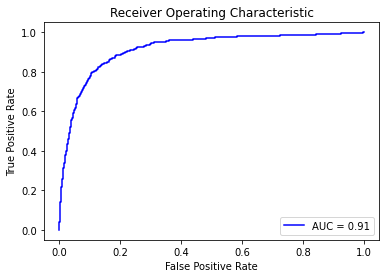

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, thresholds = metrics.roc_curve(Test.Target, Test.pred_prob)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
model_tracker = pd.DataFrame(columns = ['model_id','architecture','batch_size','img_size','optimizer','lossfunction','weight_path','logs_path','Colab_URL','comments'])

In [25]:
model_tracker.append({'model_id' : "UN_1",
                      'architecture' : "U-Net IncpetionV3", 
                      'batch_size' : 1,
                      'img_size' : 512,
                      'learning_rate' : 0.00001, 
                      'optimizer' : "Adam", 
                      'lossfunction' : "Binary CrossEntropy", 
                      'weight_path' : "/content/drive/MyDrive/weights/Unet_Inception_1_max_val_dice.hdf5 , /content/drive/MyDrive/weights/Unet_Inception_1_min_val_loss.hdf5", 
                      'logs_path' : "/content/drive/MyDrive/logs/Unet_Inception_1.csv", 
                      'Colab_URL' : "https://colab.research.google.com/drive/1m_V1-uCuR3uo--0Lj8e_cZyQAJ5e5YCB#scrollTo=U1OqRMPOr5rD",
                      'comments' :"The image size was 512 x 512 and it has a great AUC score of 0.91" }, ignore_index = True)

,model_id,architecture,batch_size,img_size,optimizer,lossfunction,weight_path,logs_path,Colab_URL,comments,learning_rate
0,UN_1,U-Net IncpetionV3,1,512,Adam,Binary CrossEntropy,/content/drive/MyDrive/weights/Unet_Inception_...,/content/drive/MyDrive/logs/Unet_Inception_1.csv,https://colab.research.google.com/drive/1m_V1-...,The image size was 512 x 512 and it has a grea...,0.00001


In [26]:
model_tracker.to_csv('/content/drive/MyDrive/Model_Tracker_Deeptek_Segmentation.csv')